<h1>Otimização de Custos de Plano de Saúde</h1> 

<p>Uma empresa do ramo alimentício tem mais de 20 mil colaboradores em todo o Brasil. Com o passar 
dos anos a empresa percebeu um aumento no custo do plano de saúde com seus colaboradores. Como 
forma de entender esse comportamento, a gerência de Benefícios e Bem Estar da Diretoria de Pessoas 
conduziu uma pesquisa interna com um grupo de 1.338 colaboradores sorteados aleatoriamente. 
A gerência acredita que fatores como fumo e obesidade podem estar relacionados com o maior uso do 
plano de saúde, o que acaba elevando os custos. Portanto, os colaboradores da pesquisa responderam 
características pessoais como o Índice de Massa Corpórea (IMC), Qte de Filhos e se fazem uso de 
cigarros.</p>


<h2>O Desafio e o Objetivo do Projeto</h2>
<p> O desafio proposto neste projeto é utilizar as ferramentas da Ciência de Dados e Machine Learning para:</p>
<ul>
    <li>Analisar os dados coletados na pesquisa para identificar os fatores que mais influenciam o custo individual do plano de saúde.</li>
    <li>Construir um modelo preditivo capaz de estimar o custo de saúde com base nas características dos colaboradores (Idade, Sexo, IMC, Quantidade de Filhos, Status de Fumante, Região).</li>
    <li>Validar as hipóteses da gerência e fornecer insights acionáveis para potenciais estratégias de otimização de custos e promoção de bem-estar.</li>
</ul>

<h2>Os Dados</h2>
<p>A análise se baseia nos dados da pesquisa interna, contendo informações sobre Idade, Sexo, Índice de Massa Corpórea (IMC), Quantidade de Filhos, Status de Fumante e Região de residência/trabalho dos 1.338 colaboradores participantes, além do custo individual do plano de saúde associado a cada um.</p>

<hr>

# Preparação do Ambiente e Carregamento dos Dados

In [1]:

# Importando as bibliotecas essenciais de manipulação e visualização

import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from IPython.display import Image

# Importando componentes do Scikit-learn
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configurando o tema padrão do Plotly
pio.templates.default = "plotly_white"
print("Tema do Plotly definido como 'plotly_white'.")

# Para ignorar warnings
import warnings
warnings.filterwarnings('ignore')

print("Bibliotecas principais importadas.")

# --- Carregamento do Dataset ---

# Defina o caminho correto para o seu arquivo Excel aqui
caminho_arquivo = 'data/base_plano_de_saude.xlsx'

try:
    # Lendo a planilha 'base' do arquivo Excel para um DataFrame pandas
    df = pd.read_excel(caminho_arquivo, sheet_name='base')
    print(f"\nDataset carregado com sucesso do arquivo: {caminho_arquivo}")
    dados_carregados = True # Flag para indicar que os dados foram carregados
except FileNotFoundError:
    print(f"\nErro Crítico: O arquivo '{caminho_arquivo}' não foi encontrado.")
    print("Por favor, verifique se o nome do arquivo e o caminho estão corretos.")
    print("O restante do script depende deste arquivo.")
    dados_carregados = False # Flag indicando falha no carregamento
except Exception as e:
    print(f"\nErro ao tentar ler o arquivo Excel: {e}")
    dados_carregados = False


if dados_carregados:
    print("Ambiente pronto e dados carregados.")
else:
    print("\nNão foi possível carregar os dados. Verifique o erro acima antes de continuar.")

Tema do Plotly definido como 'plotly_white'.
Bibliotecas principais importadas.

Dataset carregado com sucesso do arquivo: data/base_plano_de_saude.xlsx
Ambiente pronto e dados carregados.


---

# Inspeção Inicial dos Dados

In [2]:

if 'dados_carregados' in locals() and dados_carregados:

    print("\n--- 1. Visualizando as primeiras 5 linhas (head) ---")
    print(df.head())

    print("\n--- 2. Informações Gerais do DataFrame (info) ---")
    df.info()

    print("\n--- 3. Dimensões do DataFrame (shape) ---")
    print(f"O DataFrame possui {df.shape[0]} linhas e {df.shape[1]} colunas.")

    print("\n--- 4. Estatísticas Descritivas para Colunas Numéricas (describe) ---")
    print(df.describe())

    print("\n--- 5. Verificação de Valores Ausentes (isnull) ---")
    print("Contagem de valores ausentes por coluna:")
    print(df.isnull().sum())

    print("\n--- 6. Verificação de Linhas Duplicadas (duplicated) ---")
    num_duplicadas = df.duplicated().sum()
    print(f"Número de linhas duplicadas encontradas: {num_duplicadas}")

    
    if num_duplicadas > 0:
        print(f"\nRemovendo {num_duplicadas} linha(s) duplicada(s)...")
        df.drop_duplicates(inplace=True)
        
        print(f"DataFrame atualizado. Novas dimensões: {df.shape}")
        
        df.reset_index(drop=True, inplace=True)
        print("Índice do DataFrame resetado.")
    else:
        print("Nenhuma linha duplicada para remover.")

else:
    print("\nErro: Os dados não foram carregados corretamente no Bloco 1. Verifique os passos anteriores.")


--- 1. Visualizando as primeiras 5 linhas (head) ---
   Idade       Sexo     IMC  Qte_Filhos Fumante   Região  Custo_Saude
0     19   Feminino  27.900           0     Sim   Centro  1688.492400
1     18  Masculino  33.770           1     Não  Sudeste   172.555230
2     28  Masculino  33.000           3     Não  Sudeste   444.946200
3     33  Masculino  22.705           0     Não    Norte  2198.447061
4     32  Masculino  28.880           0     Não    Norte   386.685520

--- 2. Informações Gerais do DataFrame (info) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Idade        1338 non-null   int64  
 1   Sexo         1338 non-null   object 
 2   IMC          1338 non-null   float64
 3   Qte_Filhos   1338 non-null   int64  
 4   Fumante      1338 non-null   object 
 5   Região       1338 non-null   object 
 6   Custo_Saude  1338 non-null  

---

# EDA 

## EDA - Conhecendo os Personagens

In [3]:
# Certificando que o DataFrame 'df' existe e não está vazio
if 'df' in locals() and not df.empty:

    print("\n--- EDA - Conhecendo os Personagens (Variáveis) ---")

    # Identificando a variável alvo
    target = 'Custo_Saude'
    print(f"\nProtagonista (Variável Alvo): {target}")
    print(f"Tipo: {df[target].dtype}")

    # Identificando as features (variáveis independentes)
    features = df.drop(target, axis=1).columns.tolist()
    print(f"\nDemais Personagens (Features): {features}")

    # Separando as features por tipo (Numéricas vs. Categóricas)
    colunas_numericas = df[features].select_dtypes(include=np.number).columns.tolist()
    colunas_categoricas = df[features].select_dtypes(include='object').columns.tolist() # 'object' geralmente indica texto/categorias

    print("\nPersonagens por Tipo:")
    print(f"  - Numéricas (Quantitativas): {colunas_numericas}")
    print(f"     - Idade: Idade do colaborador (anos).")
    print(f"     - IMC: Índice de Massa Corpórea (kg/m²).")
    print(f"     - Qte_Filhos: Número de filhos/dependentes.")
    print(f"  - Categóricas (Qualitativas): {colunas_categoricas}")
    print(f"     - Sexo: Gênero do colaborador.")
    print(f"     - Fumante: Indica se o colaborador fuma (Sim/Não).")
    print(f"     - Região: Região geográfica do colaborador.")

    # Vamos ver os valores únicos das variáveis categóricas para entender suas categorias
    print("\nInvestigando as categorias dos Personagens Categóricos:")
    for col in colunas_categoricas:
        print(f"  - {col}: {df[col].unique()} (Total: {df[col].nunique()} categorias)")

else:
    print("\nErro: DataFrame 'df' não encontrado ou vazio. Execute as celulas anteriores.")


--- EDA - Conhecendo os Personagens (Variáveis) ---

Protagonista (Variável Alvo): Custo_Saude
Tipo: float64

Demais Personagens (Features): ['Idade', 'Sexo', 'IMC', 'Qte_Filhos', 'Fumante', 'Região']

Personagens por Tipo:
  - Numéricas (Quantitativas): ['Idade', 'IMC', 'Qte_Filhos']
     - Idade: Idade do colaborador (anos).
     - IMC: Índice de Massa Corpórea (kg/m²).
     - Qte_Filhos: Número de filhos/dependentes.
  - Categóricas (Qualitativas): ['Sexo', 'Fumante', 'Região']
     - Sexo: Gênero do colaborador.
     - Fumante: Indica se o colaborador fuma (Sim/Não).
     - Região: Região geográfica do colaborador.

Investigando as categorias dos Personagens Categóricos:
  - Sexo: ['Feminino' 'Masculino'] (Total: 2 categorias)
  - Fumante: ['Sim' 'Não'] (Total: 2 categorias)
  - Região: ['Centro' 'Sudeste' 'Norte' 'Nordeste'] (Total: 4 categorias)


---

## EDA - O Problema (Distribuição do Custo_Saude)


--- EDA - Identificando o Problema (Análise da Variável Alvo: Custo_Saude) ---

Gerando Histograma dos Custos...


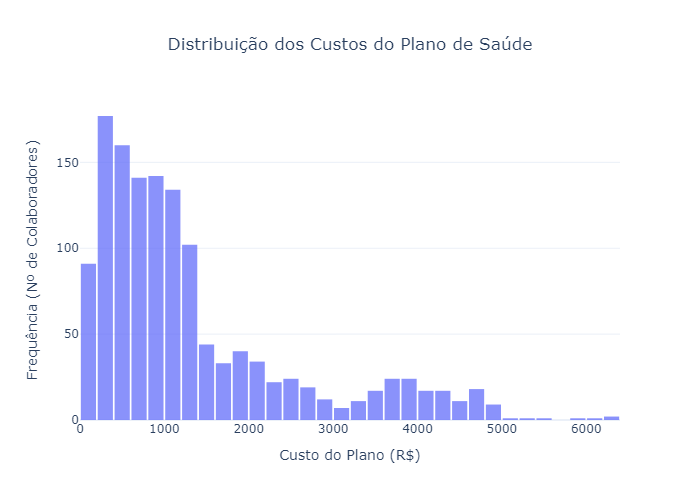


Gerando Box Plot dos Custos...


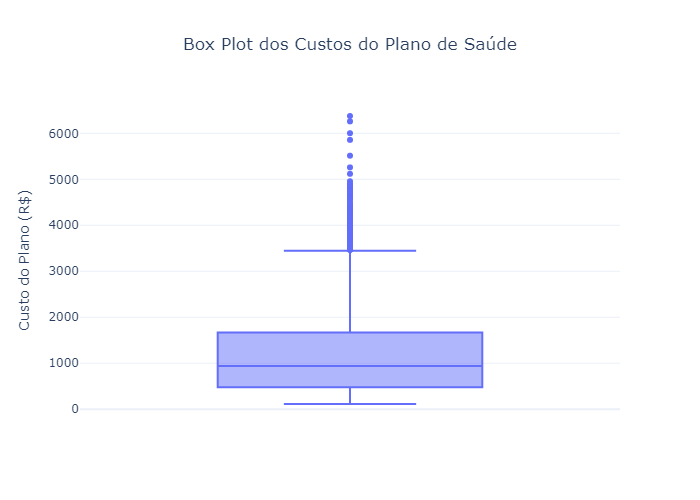


Medida de Assimetria (Skewness) da distribuição de Custo_Saude: 1.52
Interpretação: Assimetria fortemente positiva (à direita).


In [4]:
# Certificando que o DataFrame 'df' existe e a coluna 'Custo_Saude' também
if 'df' in locals() and 'Custo_Saude' in df.columns:

    print("\n--- EDA - Identificando o Problema (Análise da Variável Alvo: Custo_Saude) ---")

    # 1. Histograma da Distribuição dos Custos
    fig_hist_custo = px.histogram(df,
                                  x='Custo_Saude',
                                  nbins=50, 
                                  title='Distribuição dos Custos do Plano de Saúde',
                                  labels={'Custo_Saude': 'Custo do Plano (R$)'}, 
                                  opacity=0.75) # Leve transparência nas barras

    # Melhorando o layout do histograma
    fig_hist_custo.update_layout(yaxis_title='Frequência (Nº de Colaboradores)', 
                                 bargap=0.1, 
                                 title_x=0.5) # Centraliza o título
    print("\nGerando Histograma dos Custos...")
    #fig_hist_custo.show()


    fig_hist_custo.write_image("figura_plotly.png", engine="kaleido")

    # Exibir a imagem no notebook
    display(Image(filename="figura_plotly.png"))

    # 2. Box Plot dos Custos
    fig_box_custo = px.box(df,
                           y='Custo_Saude',
                           title='Box Plot dos Custos do Plano de Saúde',
                           labels={'Custo_Saude': 'Custo do Plano (R$)'},
                           points='outliers', # Exibe os pontos considerados outliers
                           hover_data=df.columns) # Mostra todos os dados da linha no hover

    # Melhorando o layout do box plot
    fig_box_custo.update_layout(title_x=0.5) # Centraliza o título
    print("\nGerando Box Plot dos Custos...")
    #fig_box_custo.show()
    fig_box_custo.write_image("fig_box_custo.png", engine="kaleido")

    # Exibir a imagem no notebook
    display(Image(filename="fig_box_custo.png"))

    # 3. Calculando a Assimetria (Skewness)
    skewness_custo = df['Custo_Saude'].skew()
    print(f"\nMedida de Assimetria (Skewness) da distribuição de Custo_Saude: {skewness_custo:.2f}")

    # Interpretação da Assimetria
    if skewness_custo > 1:
        print("Interpretação: Assimetria fortemente positiva (à direita).")
    elif skewness_custo > 0.5:
        print("Interpretação: Assimetria moderadamente positiva (à direita).")
    elif skewness_custo > -0.5:
        print("Interpretação: Distribuição aproximadamente simétrica.")
    elif skewness_custo > -1:
        print("Interpretação: Assimetria moderadamente negativa (à esquerda).")
    else:
        print("Interpretação: Assimetria fortemente negativa (à esquerda).")

else:
    print("\nErro: DataFrame 'df' ou coluna 'Custo_Saude' não encontrados. Verifique os blocos anteriores.")

---

## EDA - Fatores Suspeitos (Fumante, IMC, Idade)


--- EDA - Investigando os Principais Suspeitos ---

Investigando: Fumante vs Custo de Saúde...


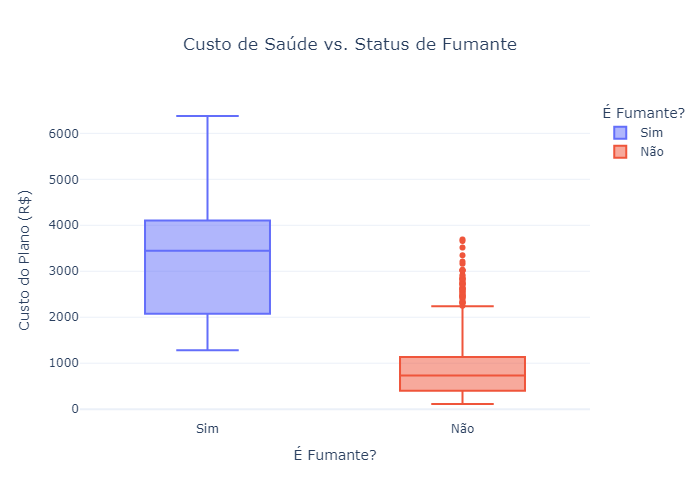


Investigando: IMC vs Custo de Saúde...


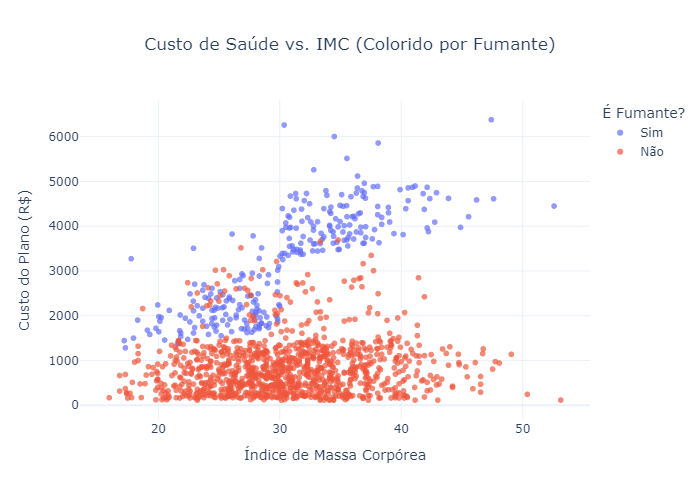


Investigando: Idade vs Custo de Saúde...


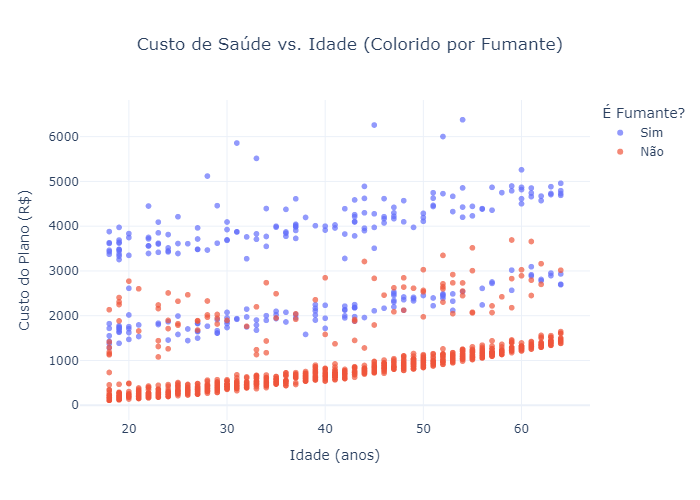

In [5]:
# Certificando que 'df' existe e contém as colunas necessárias
if 'df' in locals() and all(col in df.columns for col in ['Custo_Saude', 'Fumante', 'IMC', 'Idade']):

    print("\n--- EDA - Investigando os Principais Suspeitos ---")

    # 3.1 Suspeito: Fumante (Categórico) vs Custo_Saude (Numérico)
    print("\nInvestigando: Fumante vs Custo de Saúde...")
    fig_box_fumante = px.box(df,
                             x='Fumante',         # Eixo X: Categoria (Fumante Sim/Não)
                             y='Custo_Saude',     # Eixo Y: Variável numérica (Custo)
                             color='Fumante',     # Colore as caixas pela categoria
                             title='Custo de Saúde vs. Status de Fumante',
                             labels={'Custo_Saude': 'Custo do Plano (R$)', 'Fumante': 'É Fumante?'},
                             points='outliers') # Mostra outliers
    fig_box_fumante.update_layout(title_x=0.5)
    #fig_box_fumante.show()
    
    
    fig_box_fumante.write_image("fig_box_fumante.png", engine="kaleido")

    # Exibir a imagem no notebook
    display(Image(filename="fig_box_fumante.png"))

    # 3.2 Suspeito: IMC (Numérico) vs Custo_Saude (Numérico)
    print("\nInvestigando: IMC vs Custo de Saúde...")
    # Usar 'color="Fumante"' aqui já começa a investigar interações (Reviravolta!)
    fig_scatter_imc = px.scatter(df,
                                 x='IMC',             # Eixo X: IMC
                                 y='Custo_Saude',     # Eixo Y: Custo
                                 color='Fumante',     # Colore os pontos por status de Fumante
                                 title='Custo de Saúde vs. IMC (Colorido por Fumante)',
                                 labels={'Custo_Saude': 'Custo do Plano (R$)', 'IMC': 'Índice de Massa Corpórea'},
                                 opacity=0.7,         # Leve transparência para ver sobreposição
                                 hover_data=['Idade', 'Qte_Filhos']) # Info extra no hover
    fig_scatter_imc.update_layout(title_x=0.5, legend_title_text='É Fumante?')
    #fig_scatter_imc.show()

    fig_box_fumante.update_layout(title_x=0.5)
   
    fig_scatter_imc.write_image("fig_scatter_imc.png", engine="kaleido")
    display(Image(filename="fig_scatter_imc.png"))
    

    # 3.3 Suspeito: Idade (Numérico) vs Custo_Saude (Numérico)
    print("\nInvestigando: Idade vs Custo de Saúde...")
    fig_scatter_idade = px.scatter(df,
                                   x='Idade',           # Eixo X: Idade
                                   y='Custo_Saude',     # Eixo Y: Custo
                                   color='Fumante',     # Colore também por Fumante
                                   title='Custo de Saúde vs. Idade (Colorido por Fumante)',
                                   labels={'Custo_Saude': 'Custo do Plano (R$)', 'Idade': 'Idade (anos)'},
                                   opacity=0.7,
                                   hover_data=['IMC', 'Qte_Filhos'])
    fig_scatter_idade.update_layout(title_x=0.5, legend_title_text='É Fumante?')
    #fig_scatter_idade.show()

    fig_scatter_idade.write_image("fig_scatter_idade.png", engine="kaleido")
    display(Image(filename="fig_scatter_idade.png"))

    

else:
    print("\nErro: DataFrame 'df' ou colunas essenciais não encontrados. Verifique os blocos anteriores.")

---

## EDA - (Continuação): Outros Suspeitos


--- EDA - Investigando Outros Suspeitos ---

Investigando: Quantidade de Filhos vs Custo de Saúde...


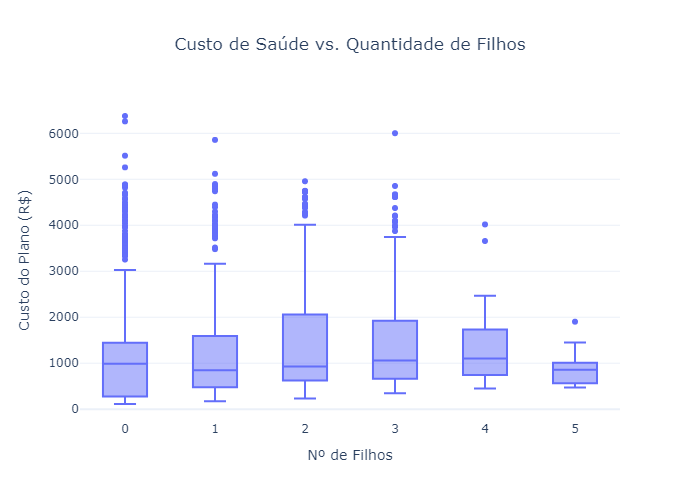


Investigando: Sexo vs Custo de Saúde...


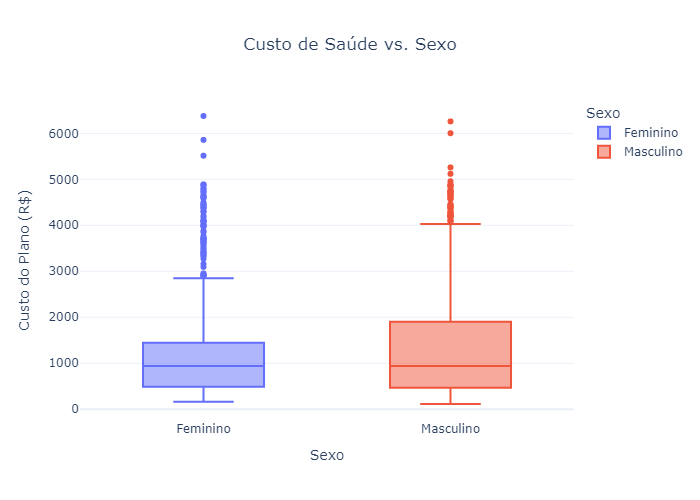


Investigando: Região vs Custo de Saúde...


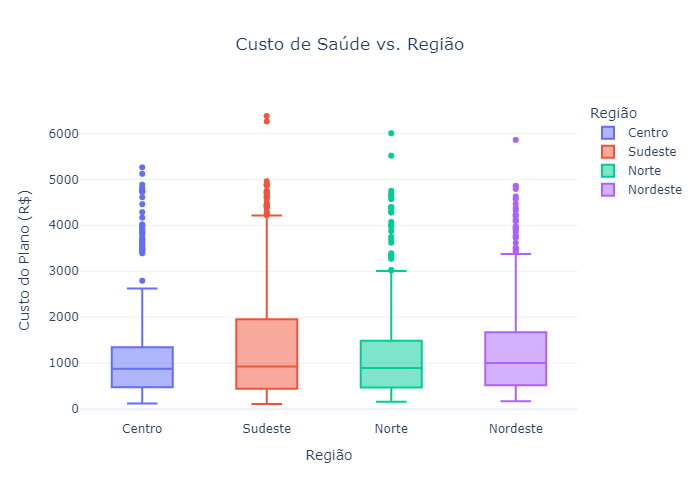

In [6]:
# Certificando que 'df' existe e contém as colunas necessárias
if 'df' in locals() and all(col in df.columns for col in ['Custo_Saude', 'Qte_Filhos', 'Sexo', 'Região']):

    print("\n--- EDA - Investigando Outros Suspeitos ---")

    # 3.4 Suspeito: Qte_Filhos (Numérica/Ordinal baixa) vs Custo_Saude (Numérico)
    print("\nInvestigando: Quantidade de Filhos vs Custo de Saúde...")
    # Tratar Qte_Filhos como categórica no eixo X melhora a visualização do box plot
    fig_box_filhos = px.box(df,
                            x=df['Qte_Filhos'].astype(str), # Converte para string para tratar como categoria
                            y='Custo_Saude',
                            title='Custo de Saúde vs. Quantidade de Filhos',
                            labels={'Custo_Saude': 'Custo do Plano (R$)', 'x': 'Nº de Filhos'},
                            category_orders={'x': sorted(df['Qte_Filhos'].astype(str).unique())}, # Ordena o eixo X
                            points='outliers')
    fig_box_filhos.update_layout(title_x=0.5)
    #fig_box_filhos.show()

    fig_box_filhos.write_image("fig_box_filhos.png", engine="kaleido")
    display(Image(filename="fig_box_filhos.png"))

    # 3.5 Suspeito: Sexo (Categórico) vs Custo_Saude (Numérico)
    print("\nInvestigando: Sexo vs Custo de Saúde...")
    fig_box_sexo = px.box(df,
                          x='Sexo',
                          y='Custo_Saude',
                          color='Sexo', # Colore as caixas
                          title='Custo de Saúde vs. Sexo',
                          labels={'Custo_Saude': 'Custo do Plano (R$)', 'Sexo': 'Sexo'},
                          points='outliers')
    fig_box_sexo.update_layout(title_x=0.5)
    #fig_box_sexo.show()

    fig_box_sexo.write_image("fig_box_sexo.png", engine="kaleido")
    display(Image(filename="fig_box_sexo.png"))

    # 3.6 Suspeito: Região (Categórico) vs Custo_Saude (Numérico)
    print("\nInvestigando: Região vs Custo de Saúde...")
    fig_box_regiao = px.box(df,
                            x='Região',
                            y='Custo_Saude',
                            color='Região', # Colore as caixas
                            title='Custo de Saúde vs. Região',
                            labels={'Custo_Saude': 'Custo do Plano (R$)', 'Região': 'Região'},
                            points='outliers')
    fig_box_regiao.update_layout(title_x=0.5)
    #fig_box_regiao.show()

    fig_box_regiao.write_image("fig_box_regiao.png", engine="kaleido")
    display(Image(filename="fig_box_regiao.png"))
    

else:
    print("\nErro: DataFrame 'df' ou colunas essenciais não encontrados. Verifique os blocos anteriores.")

---

## EDA - Formulação das Hipóteses


<h3>Com base nas análises anteriores, formulei as seguintes hipóteses:</h3>

- H1 (Fumante): Ser fumante está associado a custos de saúde drasticamente mais elevados.
   -> Evidência: Forte separação visual no Box Plot Fumante vs Custo.

- H2 (Idade): O custo de saúde tende a aumentar com a idade.
   -> Evidência: Tendência positiva observada no Scatter Plot Idade vs Custo.

- H3 (IMC): Um IMC mais alto está associado a custos de saúde maiores.
   -> Evidência: Tendência positiva observada no Scatter Plot IMC vs Custo.

- H4 (Interação Fumo-Idade/IMC): O impacto da Idade e do IMC nos custos é significativamente maior para fumantes.
   -> Evidência: Inclinação mais acentuada e separação de grupos nos Scatter Plots coloridos por Fumante.

- H5 (Qte_Filhos): A quantidade de filhos tem um impacto limitado ou pouco claro nos custos individuais.
   -> Evidência: Ausência de tendência clara no Box Plot Qte_Filhos vs Custo.

- H6 (Sexo): O sexo do colaborador tem um impacto limitado nos custos, menor que o do fumo.
   -> Evidência: Diferenças relativamente pequenas no Box Plot Sexo vs Custo.

- H7 (Região): Existem diferenças nos níveis de custo entre as regiões.
   -> Evidência: Variações observadas no Box Plot Região vs Custo.

---

## EDA - (Matriz de Correlação)


--- EDA - (Análise de Correlação Numérica) ---

Variáveis numéricas incluídas na análise de correlação:
['Idade', 'IMC', 'Qte_Filhos', 'Custo_Saude']

Matriz de Correlação:
             Idade   IMC  Qte_Filhos  Custo_Saude
Idade         1.00  0.11        0.04         0.30
IMC           0.11  1.00        0.01         0.20
Qte_Filhos    0.04  0.01        1.00         0.07
Custo_Saude   0.30  0.20        0.07         1.00

Gerando Heatmap da Matriz de Correlação...


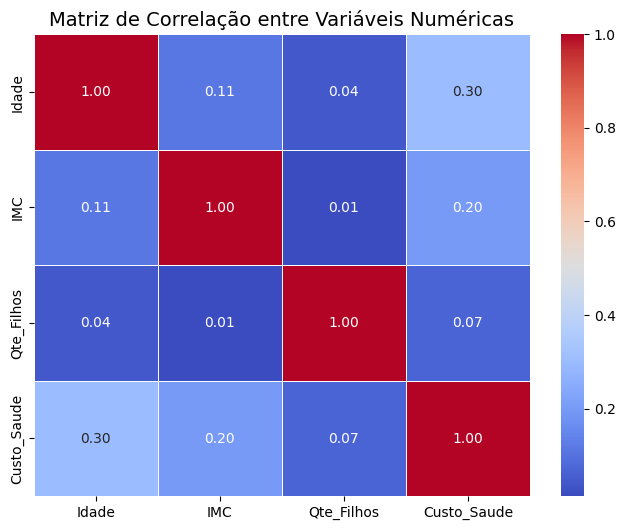

In [15]:
# Certificando que 'df' existe
if 'df' in locals():
    print("\n--- EDA - (Análise de Correlação Numérica) ---")

    # 1. Selecionar apenas as colunas numéricas
    df_numeric = df.select_dtypes(include=np.number)
    print("\nVariáveis numéricas incluídas na análise de correlação:")
    print(df_numeric.columns.tolist())

    # 2. Calcular a matriz de correlação (método de Pearson por padrão)
    correlation_matrix = df_numeric.corr()

    print("\nMatriz de Correlação:")
    # Mostrando a matriz arredondada para facilitar a leitura
    print(correlation_matrix.round(2))

    # 3. Visualizar a matriz de correlação com um Heatmap (usando Seaborn)
    print("\nGerando Heatmap da Matriz de Correlação...")
    plt.figure(figsize=(8, 6)) # Define o tamanho da figura
    sns.heatmap(correlation_matrix,
                annot=True,      # Mostra os valores de correlação nas células
                cmap='coolwarm', # Escolhe um mapa de cores (divergente é bom para correlação)
                fmt=".2f",       # Formata os números para 2 casas decimais
                linewidths=.5)   # Adiciona linhas entre as células
    plt.title('Matriz de Correlação entre Variáveis Numéricas', fontsize=14)
    plt.show() # Exibe o gráfico gerado pelo Matplotlib/Seaborn

else:
    print("\nErro: DataFrame 'df' não encontrado. Verifique os blocos anteriores.")

---

## EDA - Clímax (Síntese das Descobertas)

<h3>Principais Descobertas da Exploração</h3>

Após investigar os personagens, o problema, os suspeitos e as interações, temos às seguintes conclusões principais:

1. Impacto Dominante do Fumo:
   - A variável 'Fumante' é o fator com maior poder de separação dos custos.
   - Fumantes apresentam custos significativamente mais elevados e variáveis que não fumantes.

2. Influência Condicional de Idade e IMC:
   - 'Idade' e 'IMC' têm correlação positiva com 'Custo_Saude' (0.30 e 0.20, respectivamente).
   - No entanto, o impacto real dessas variáveis no custo é muito mais acentuado para fumantes.
   - Existe uma forte INTERAÇÃO entre Fumo, Idade e IMC.

3. Estrutura de Custos em Grupos:
   - Os dados sugerem a existência de grupos distintos de custo, fortemente relacionados ao status de fumante.
   - Não fumantes: custos geralmente mais baixos, com aumento gradual com idade/IMC.
   - Fumantes: custos partem de um patamar mais alto e aumentam mais rapidamente com idade/IMC.

4. Fatores de Influência Secundária:
   - 'Região' apresenta algumas diferenças nos custos entre localidades.
   - 'Sexo' e 'Qte_Filhos' parecem ter um impacto limitado ou menos claro nos custos individuais.

5. Implicações da Assimetria do Custo:
   - A distribuição do 'Custo_Saude' é fortemente assimétrica à direita.
   - Isso indica que prever corretamente os altos custos será crucial e potencialmente desafiador para o modelo.

Essas descobertas guiarão as próximas etapas de pré-processamento e modelagem.

---

## EDA - Desfecho e Próximos Passos

<h3>Insights Finais e Implicações</h3>

Insights Consolidados da Análise Exploratória:
1. Fatores primários de custo identificados: Fumante, Idade, IMC.
2. Interações entre Fumo, Idade e IMC são cruciais para explicar custos elevados.
3. Região pode ter influência secundária; Sexo e Qte_Filhos parecem menos impactantes.
4. A forte assimetria do Custo_Saude é um ponto de atenção para a modelagem.

Decisões e Próximos Passos para Pré-processamento e Modelagem:
1. Pré-processamento:
   - Aplicar One-Hot Encoding em 'Sexo', 'Fumante', 'Região'.
   - Aplicar StandardScaler em 'Idade', 'IMC', 'Qte_Filhos'.
   - Utilizar ColumnTransformer para aplicar transformações específicas por tipo de coluna.
2. Engenharia de Features: Não criar features de interação manualmente *neste momento*.
3. Modelos a Testar: Linear Regression, Ridge, Lasso, Decision Tree, Random Forest, Gradient Boosting.
4. Avaliação: Utilizar K-Fold Cross-Validation no treino e métricas R², MAE, RMSE.

A fase de Análise Exploratória de Dados está concluída.
Entendi melhor a dinâmica dos dados e temos um plano claro para a construção do modelo.

---

# Pré-processamento - Separação (X/y) e Divisão (Treino/Teste)

In [8]:
# Certificando que 'df' existe
if 'df' in locals():
    print("\n--- Fase 2: Pré-processamento - Iniciando ---")

    # 1. Separar Features (X) e Variável Alvo (y)
    X = df.drop('Custo_Saude', axis=1) # Todas as colunas, exceto a alvo
    y = df['Custo_Saude']             # Apenas a coluna alvo

    print("\nVariáveis Independentes (Features - X) selecionadas:")
    print(X.columns.tolist())
    print(f"Dimensões de X: {X.shape}")

    print("\nVariável Dependente (Alvo - y) selecionada:")
    print(y.name)
    print(f"Dimensões de y: {y.shape}")

    # 2. Dividir os dados em Conjunto de Treino e Conjunto de Teste
    #  E usar 80% para treino e 20% para teste (test_size=0.2)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("\nDados divididos em conjuntos de treino e teste:")
    print(f"  - X_train: {X_train.shape}") # Features de treino
    print(f"  - y_train: {y_train.shape}")   # Alvo de treino
    print(f"  - X_test:  {X_test.shape}")  # Features de teste
    print(f"  - y_test:  {y_test.shape}")    # Alvo de teste

    print("\nPrimeiro passo do pré-processamento concluído: Separação X/y e divisão treino/teste.")

else:
    print("\nErro: DataFrame 'df' não encontrado. Verifique os blocos anteriores.")


--- Fase 2: Pré-processamento - Iniciando ---

Variáveis Independentes (Features - X) selecionadas:
['Idade', 'Sexo', 'IMC', 'Qte_Filhos', 'Fumante', 'Região']
Dimensões de X: (1337, 6)

Variável Dependente (Alvo - y) selecionada:
Custo_Saude
Dimensões de y: (1337,)

Dados divididos em conjuntos de treino e teste:
  - X_train: (1069, 6)
  - y_train: (1069,)
  - X_test:  (268, 6)
  - y_test:  (268,)

Primeiro passo do pré-processamento concluído: Separação X/y e divisão treino/teste.


---

## Pré-processamento - Definição e Aplicação do ColumnTransformer

In [9]:

# Certificando que X_train e X_test existem (criados no bloco anterior)
if 'X_train' in locals() and 'X_test' in locals():

    print("\n--- Pré-processamento: Definindo e Aplicando Transformadores ---")

    # 1. Identificar novamente as colunas por tipo (baseado em X_train)
    colunas_numericas = X_train.select_dtypes(include=np.number).columns.tolist()
    colunas_categoricas = X_train.select_dtypes(include='object').columns.tolist()

    print(f"\nColunas Numéricas identificadas para Scaling: {colunas_numericas}")
    print(f"Colunas Categóricas identificadas para One-Hot Encoding: {colunas_categoricas}")

    # 2. Criar os transformadores individuais
    scaler = StandardScaler()
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    # 3. Criar o ColumnTransformer
    # Lista de tuplas: (nome_passo, transformador, colunas_a_aplicar)
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', scaler, colunas_numericas), # Aplica scaler nas numéricas
            ('cat', ohe, colunas_categoricas)   # Aplica ohe nas categóricas
        ],
        remainder='passthrough' 
    )

    print("\nColumnTransformer ('preprocessor') criado com sucesso.")
    print("Ele aplicará StandardScaler nas numéricas e OneHotEncoder nas categóricas.")

    # 4. AJUSTAR o pré-processador SOMENTE nos dados de TREINO (X_train)
    print("\nAjustando (fit) o pré-processador aos dados de treino (X_train)...")
    preprocessor.fit(X_train)
    print("Pré-processador ajustado!")

    # 5. TRANSFORMAR os dados de TREINO e TESTE usando o pré-processador ajustado
    print("\nTransformando (transform) os dados de treino (X_train)...")
    X_train_processed = preprocessor.transform(X_train)
    print("X_train transformado.")

    print("\nTransformando (transform) os dados de teste (X_test)...")
    X_test_processed = preprocessor.transform(X_test)
    print("X_test transformado.")

    # 6. Verificar as dimensões dos dados processados
    # O número de colunas deve ter aumentado devido ao OneHotEncoder
    print("\nDimensões dos dados após pré-processamento:")
    print(f"  - X_train_processed: {X_train_processed.shape}")
    print(f"  - X_test_processed: {X_test_processed.shape}")

    # 7. (Opcional) Visualizar as primeiras linhas dos dados processados
    # Para isso, é útil obter os nomes das novas colunas criadas
    try:
        # Obter nomes das features após as transformações
        feature_names_out = preprocessor.get_feature_names_out()
        print(f"\nNovos nomes das features após transformações: {feature_names_out.tolist()}")

        # Criar DataFrames processados para visualização (opcional)
        X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names_out, index=X_train.index)
        X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names_out, index=X_test.index)

        print("\n--- Dados de Treino Processados (X_train_processed_df) - Primeiras 5 linhas ---")
        print(X_train_processed_df.head())

    except Exception as e:
        print(f"\nNão foi possível criar DataFrame visualizável dos dados processados (get_feature_names_out pode requerer sklearn >= 1.0): {e}")
        print("Continuaremos usando os arrays NumPy 'X_train_processed' e 'X_test_processed'.")

else:
    print("\nErro: X_train ou X_test não encontrados. Execute o Bloco 11 primeiro.")


--- Pré-processamento: Definindo e Aplicando Transformadores ---

Colunas Numéricas identificadas para Scaling: ['Idade', 'IMC', 'Qte_Filhos']
Colunas Categóricas identificadas para One-Hot Encoding: ['Sexo', 'Fumante', 'Região']

ColumnTransformer ('preprocessor') criado com sucesso.
Ele aplicará StandardScaler nas numéricas e OneHotEncoder nas categóricas.

Ajustando (fit) o pré-processador aos dados de treino (X_train)...
Pré-processador ajustado!

Transformando (transform) os dados de treino (X_train)...
X_train transformado.

Transformando (transform) os dados de teste (X_test)...
X_test transformado.

Dimensões dos dados após pré-processamento:
  - X_train_processed: (1069, 11)
  - X_test_processed: (268, 11)

Novos nomes das features após transformações: ['num__Idade', 'num__IMC', 'num__Qte_Filhos', 'cat__Sexo_Feminino', 'cat__Sexo_Masculino', 'cat__Fumante_Não', 'cat__Fumante_Sim', 'cat__Região_Centro', 'cat__Região_Nordeste', 'cat__Região_Norte', 'cat__Região_Sudeste']

--- D

---

# Modelagem - Definição dos Modelos e Validação Cruzada

In [10]:
# Certificando que os dados processados de treino existem
if 'X_train_processed' in locals() and 'y_train' in locals():

    print("\n--- Fase 4: Seleção e Treinamento de Modelos ---")

    # 1. Definindo os modelos candidatos
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(random_state=42), # Regularização L2
        'Lasso Regression': Lasso(random_state=42), # Regularização L1
        'Decision Tree': DecisionTreeRegressor(random_state=42), # Árvore única
        'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=-1), # Ensemble (n_jobs=-1 usa todos os cores)
        'Gradient Boosting': GradientBoostingRegressor(random_state=42) # Ensemble sequencial
    }
    print("\nModelos que serão avaliados:")
    for name in models:
        print(f"  - {name}")

    # 2. Definindo a estratégia de Validação Cruzada (K-Fold)
    # Começar com K=10 folds. Shuffle=True embaralha os dados antes de dividir.
    k = 10
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    print(f"\nEstratégia de Avaliação: K-Fold Cross-Validation com K={k}")

    # 3. Dicionário para armazenar os resultados da validação cruzada
    cv_results = {}

    # 4. Executando a Validação Cruzada para cada modelo
    print(f"\nIniciando Validação Cruzada (K={k}) nos dados de treino...")

    for name, model in models.items():
        print(f"  Avaliando {name}...")
        # cross_val_score para calcular as métricas em cada fold
        # 'scoring' define a métrica. 'r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'
        # O 'neg_' é porque o Scikit-learn tenta maximizar. Inverti o sinal de MAE e RMSE depois.
        r2_scores = cross_val_score(model, X_train_processed, y_train, cv=kf, scoring='r2', n_jobs=-1)
        mae_scores = cross_val_score(model, X_train_processed, y_train, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)
        rmse_scores = cross_val_score(model, X_train_processed, y_train, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)

        # Armazenando a média e o desvio padrão das métricas para este modelo
        cv_results[name] = {
            'R2 Média': np.mean(r2_scores),
            'R2 Std': np.std(r2_scores),
            'MAE Média': -np.mean(mae_scores), # Inverte o sinal para obter MAE positivo
            'MAE Std': np.std(mae_scores),
            'RMSE Média': -np.mean(rmse_scores), # Inverte o sinal para obter RMSE positivo
            'RMSE Std': np.std(rmse_scores)
        }
    print("Validação Cruzada concluída para todos os modelos.")

    # 5. Analisando os resultados
    cv_results_df = pd.DataFrame(cv_results).T # Converte para DataFrame e transpõe
    # Ordenando os resultados pela Média do R² (do maior para o menor)
    cv_results_df = cv_results_df.sort_values(by='R2 Média', ascending=False)

    print("\n--- Resultados da Validação Cruzada (Médias e Desvios Padrão) ---")
    # Formatando a saída para melhor leitura
    print(cv_results_df.to_string(formatters={
        'R2 Média': '{:.4f}'.format, 'R2 Std': '{:.4f}'.format,
        'MAE Média': '{:.2f}'.format, 'MAE Std': '{:.2f}'.format,
        'RMSE Média': '{:.2f}'.format, 'RMSE Std': '{:.2f}'.format
    }))

else:
    print("\nErro: Dados de treino processados (X_train_processed, y_train) não encontrados. Verifique os blocos anteriores.")


--- Fase 4: Seleção e Treinamento de Modelos ---

Modelos que serão avaliados:
  - Linear Regression
  - Ridge Regression
  - Lasso Regression
  - Decision Tree
  - Random Forest
  - Gradient Boosting

Estratégia de Avaliação: K-Fold Cross-Validation com K=10

Iniciando Validação Cruzada (K=10) nos dados de treino...
  Avaliando Linear Regression...
  Avaliando Ridge Regression...
  Avaliando Lasso Regression...
  Avaliando Decision Tree...
  Avaliando Random Forest...
  Avaliando Gradient Boosting...
Validação Cruzada concluída para todos os modelos.

--- Resultados da Validação Cruzada (Médias e Desvios Padrão) ---
                  R2 Média R2 Std MAE Média MAE Std RMSE Média RMSE Std
Gradient Boosting   0.8281 0.0748    259.25   41.24     464.80    72.21
Random Forest       0.8160 0.0708    271.33   31.14     483.73    52.98
Lasso Regression    0.7106 0.0848    423.71   40.74     613.07    54.47
Ridge Regression    0.7103 0.0848    424.32   40.71     613.36    54.43
Linear Regress

---

## Modelagem - Treinamento do Modelo Campeão Final Escolhido

In [11]:
# Certificando que os dados de treino processados e o nome do modelo escolhido existem
if 'X_train_processed' in locals() and 'y_train' in locals():
    
    final_model = GradientBoostingRegressor(random_state=42)
    best_model_name = "Gradient Boosting Regressor" # Guardando o nome para referência

    print(f"\n--- Treinando o Modelo Final: {best_model_name} ---")
    print("Usando todo o conjunto de treino (X_train_processed, y_train)...")

    # Treinando o modelo
    final_model.fit(X_train_processed, y_train)

    print(f"\nModelo '{best_model_name}' treinado com sucesso!")
    print("Pronto para avaliação no conjunto de teste.")

    # Guardar o nome do modelo e o próprio modelo para a próxima fase
    model_treinado = True

else:
    print("\nErro: Dados de treino processados (X_train_processed, y_train) não encontrados. Verifique os blocos anteriores.")
    model_treinado = False


--- Treinando o Modelo Final: Gradient Boosting Regressor ---
Usando todo o conjunto de treino (X_train_processed, y_train)...

Modelo 'Gradient Boosting Regressor' treinado com sucesso!
Pronto para avaliação no conjunto de teste.


---

# Avaliação Final do Modelo no Conjunto de Teste


--- Fase 5: Avaliação Final do Modelo (Gradient Boosting Regressor) no Conjunto de Teste ---
Realizando predições (predict) no conjunto de teste (X_test_processed)...
Predições concluídas.

--- Métricas de Desempenho no Conjunto de Teste ---
  R² (Coeficiente de Determinação): 0.9007
  MAE (Erro Médio Absoluto): R$ 253.50
  RMSE (Raiz do Erro Quadrático Médio): R$ 427.21

--- Comparação: Métricas do Teste vs. Médias da Validação Cruzada ---
  Métrica   | Teste   | CV Média (K=10)
------------|---------|----------------
  R²        | 0.9007  | 0.8281
  MAE (R$)  | 253.50  | 259.25
  RMSE (R$) | 427.21  | 464.80

  Interpretação: O desempenho no teste está consistente com a validação cruzada. Boa generalização!

Gerando gráfico: Valores Reais vs. Valores Preditos...


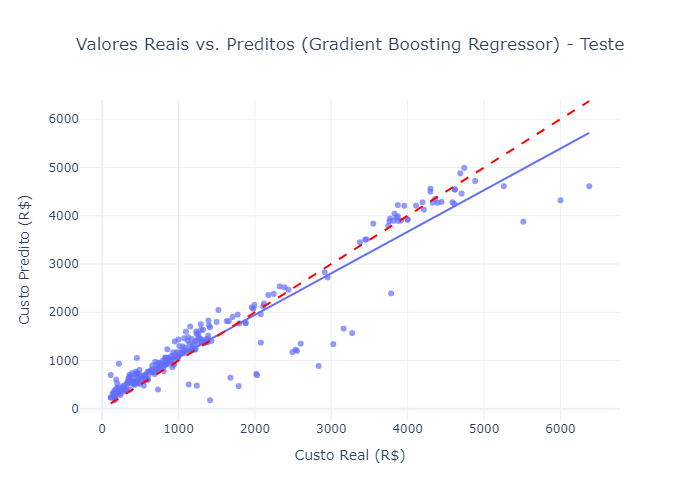


Gerando gráficos de análise de resíduos...


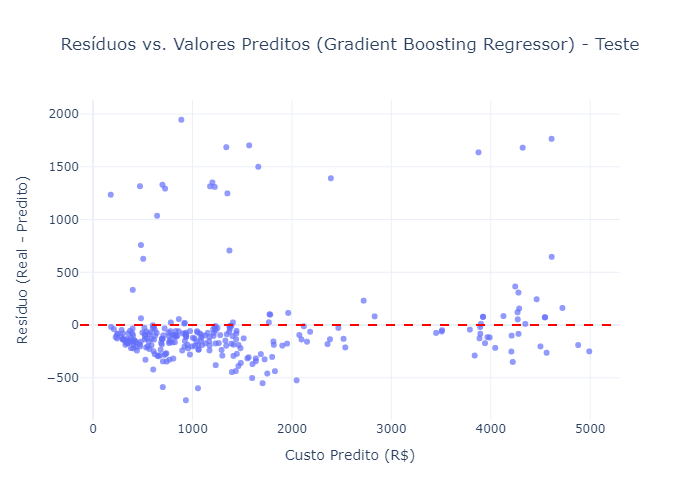

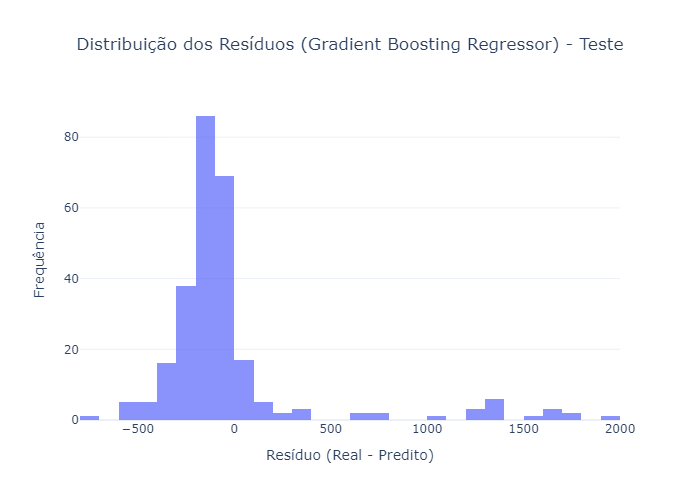

In [12]:
if 'model_treinado' in locals() and model_treinado and 'X_test_processed' in locals() and 'y_test' in locals():

    print(f"\n--- Fase 5: Avaliação Final do Modelo ({best_model_name}) no Conjunto de Teste ---")

    # 1. Fazer predições no conjunto de teste
    print("Realizando predições (predict) no conjunto de teste (X_test_processed)...")
    y_pred = final_model.predict(X_test_processed)
    print("Predições concluídas.")

    # 2. Calcular as métricas de avaliação no teste
    r2_test = r2_score(y_test, y_pred)
    mae_test = mean_absolute_error(y_test, y_pred)

    # Calcula o MSE primeiro
    mse_test = mean_squared_error(y_test, y_pred)
    # Calcula o RMSE tirando a raiz quadrada do MSE
    rmse_test = np.sqrt(mse_test)
    # ---------------------

    print("\n--- Métricas de Desempenho no Conjunto de Teste ---")
    print(f"  R² (Coeficiente de Determinação): {r2_test:.4f}")
    print(f"  MAE (Erro Médio Absoluto): R$ {mae_test:.2f}")
    print(f"  RMSE (Raiz do Erro Quadrático Médio): R$ {rmse_test:.2f}") # Agora usa a variável corrigida

    # 3. Comparar com os resultados da Validação Cruzada (se disponíveis)
    if 'cv_results_df' in locals():
        # O restante do código para comparação e plotagem permanece o mesmo...
        # (O código da comparação e dos gráficos a partir daqui não precisa mudar)
        print("\n--- Comparação: Métricas do Teste vs. Médias da Validação Cruzada ---")
        print(f"  Métrica   | Teste   | CV Média (K=10)")
        print(f"------------|---------|----------------")
        # Ajuste aqui para buscar o nome correto no dataframe de resultados da CV
        cv_model_name = 'Gradient Boosting' # Ou o nome exato usado como índice no cv_results_df
        print(f"  R²        | {r2_test:.4f}  | {cv_results_df.loc[cv_model_name, 'R2 Média']:.4f}")
        print(f"  MAE (R$)  | {mae_test:<7.2f} | {cv_results_df.loc[cv_model_name, 'MAE Média']:.2f}")
        print(f"  RMSE (R$) | {rmse_test:<7.2f} | {cv_results_df.loc[cv_model_name, 'RMSE Média']:.2f}")

        # Interpretação da comparação
        if r2_test >= cv_results_df.loc[cv_model_name, 'R2 Média'] * 0.9: # Se R2 no teste é pelo menos 90% do R2 médio da CV
             print("\n  Interpretação: O desempenho no teste está consistente com a validação cruzada. Boa generalização!")
        else:
             print("\n  Interpretação: Houve uma queda no desempenho do teste em comparação com a validação cruzada.")
             print("                 Isso pode sugerir algum grau de overfitting aos dados de treino.")

    # 4. Visualizar Predições vs. Valores Reais
    print("\nGerando gráfico: Valores Reais vs. Valores Preditos...")
    results_df = pd.DataFrame({'Real': y_test, 'Predito': y_pred})
    fig_preds_vs_real = px.scatter(results_df, x='Real', y='Predito',
                                   title=f'Valores Reais vs. Preditos ({best_model_name}) - Teste',
                                   labels={'Real': 'Custo Real (R$)', 'Predito': 'Custo Predito (R$)'},
                                   opacity=0.7, trendline='ols',
                                   hover_data={'Real': ':.2f', 'Predito': ':.2f'})
    fig_preds_vs_real.add_shape(type='line', x0=y_test.min(), y0=y_test.min(),
                                x1=y_test.max(), y1=y_test.max(),
                                line=dict(color='red', dash='dash', width=2), name='Ideal')
    fig_preds_vs_real.update_layout(title_x=0.5)
    #fig_preds_vs_real.show()

    fig_preds_vs_real.write_image("fig_preds_vs_real.png", engine="kaleido")
    display(Image(filename="fig_preds_vs_real.png"))

    # 5. Analisar os Resíduos (Erro = Real - Predito)
    print("\nGerando gráficos de análise de resíduos...")
    results_df['Residuo'] = results_df['Real'] - results_df['Predito']

    fig_residuos = px.scatter(results_df, x='Predito', y='Residuo',
                              title=f'Resíduos vs. Valores Preditos ({best_model_name}) - Teste',
                              labels={'Predito': 'Custo Predito (R$)', 'Residuo': 'Resíduo (Real - Predito)'},
                              opacity=0.7)
    fig_residuos.add_hline(y=0, line_dash="dash", line_color="red")
    fig_residuos.update_layout(title_x=0.5)
    #fig_residuos.show()

    fig_residuos.write_image("fig_residuos.png", engine="kaleido")
    display(Image(filename="fig_residuos.png"))

    fig_hist_residuos = px.histogram(results_df, x='Residuo',
                                     title=f'Distribuição dos Resíduos ({best_model_name}) - Teste',
                                     labels={'Residuo': 'Resíduo (Real - Predito)'},
                                     opacity=0.75)
    fig_hist_residuos.update_layout(yaxis_title='Frequência', title_x=0.5)
    #fig_hist_residuos.show()

    fig_hist_residuos.write_image("fig_hist_residuos.png", engine="kaleido")
    display(Image(filename="fig_hist_residuos.png"))

else:
    print("\nErro: Modelo final não treinado ou dados de teste não encontrados. Verifique os blocos anteriores.")

---

# Interpretação - Importância das Features


--- Fase 6: Interpretação do Modelo (Gradient Boosting Regressor) ---

Analisando a Importância das Features...

Importância Relativa das Features (do maior para o menor):
             Feature Importance Importance (%)
    cat__Fumante_Sim     0.3771         37.71%
    cat__Fumante_Não     0.2940         29.40%
            num__IMC     0.1881         18.81%
          num__Idade     0.1225         12.25%
     num__Qte_Filhos     0.0137          1.37%
cat__Região_Nordeste     0.0018          0.18%
 cat__Sexo_Masculino     0.0010          0.10%
  cat__Região_Centro     0.0007          0.07%
   cat__Região_Norte     0.0006          0.06%
  cat__Sexo_Feminino     0.0003          0.03%
 cat__Região_Sudeste     0.0002          0.02%

Gerando gráfico de Importância das Features...


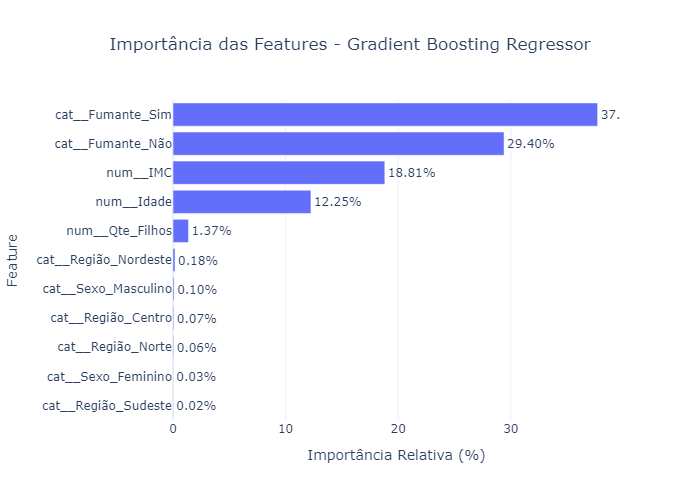

In [13]:
if 'model_treinado' in locals() and model_treinado and 'preprocessor' in locals():
    print(f"\n--- Fase 6: Interpretação do Modelo ({best_model_name}) ---")
    print("\nAnalisando a Importância das Features...")

    # 1. Verificar se o modelo tem o atributo feature_importances_
    if hasattr(final_model, 'feature_importances_'):
        importances = final_model.feature_importances_

        # 2. Obter os nomes das features do pré-processador
        try:
            # Tenta obter os nomes formatados do ColumnTransformer
            feature_names = preprocessor.get_feature_names_out()
        except Exception as e:
            print(f"  Aviso: Não foi possível obter nomes formatados das features via get_feature_names_out() ({e}).")
            # Criar nomes genéricos se falhar (menos informativo)
            feature_names = [f'feature_{i}' for i in range(len(importances))]

        # 3. Criar um DataFrame para visualizar as importâncias
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        # Calcular importância percentual para facilitar interpretação
        importance_df['Importance (%)'] = (importance_df['Importance'] / importance_df['Importance'].sum()) * 100
        # Ordenar por importância
        importance_df = importance_df.sort_values(by='Importance', ascending=False)

        print("\nImportância Relativa das Features (do maior para o menor):")
        print(importance_df.to_string(index=False, formatters={'Importance': '{:.4f}'.format, 'Importance (%)': '{:.2f}%'.format}))

        # 4. Visualizar a importância das features com Plotly Bar Chart
        print("\nGerando gráfico de Importância das Features...")
        fig_importance = px.bar(importance_df.head(15), # Mostra top 15 (ou todas se forem menos)
                                x='Importance (%)',
                                y='Feature',
                                orientation='h',
                                title=f'Importância das Features - {best_model_name}',
                                labels={'Importance (%)': 'Importância Relativa (%)', 'Feature': 'Feature'},
                                text='Importance (%)')

        fig_importance.update_layout(yaxis={'categoryorder':'total ascending'}, # Ordena barras
                                     title_x=0.5,
                                     xaxis_title='Importância Relativa (%)',
                                     yaxis_title='Feature')
        fig_importance.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
        #fig_importance.show()
        
        fig_importance.write_image("fig_importance.png", engine="kaleido")
        display(Image(filename="fig_importance.png"))

    else:
        print(f"\nO modelo {best_model_name} não possui o atributo 'feature_importances_'.")
        

else:
    print("\nErro: Modelo final não treinado ou pré-processador não encontrado. Verifique os blocos anteriores.")

---

# Conclusões Finais do Projeto

--- Conclusões Finais do Projeto: Otimização de Custos de Plano de Saúde ---

1. Desempenho do Modelo Preditivo:
   - Modelo Utilizado: Gradient Boosting Regressor
   - R² no Conjunto de Teste: 0.9007 (~90.1% da variância explicada)
   - MAE no Conjunto de Teste: R$ 253.50 (Erro médio da previsão)
   - O modelo demonstrou excelente capacidade de generalização para prever os custos em dados não vistos.

2. Principais Fatores Determinantes do Custo (Baseado na Importância das Features):
   - O fator de MAIOR impacto no custo do plano de saúde é o STATUS DE FUMANTE.
   - Em seguida, o ÍNDICE DE MASSA CORPÓREA (IMC) e a IDADE do colaborador são os fatores mais relevantes.
   - A REGIÃO do colaborador também mostrou alguma influência nos custos.
   - Variáveis como Sexo e Quantidade de Filhos tiveram importância significativamente menor neste modelo.
   - Estes achados confirmam e quantificam as suspeitas iniciais da gerência e os insights da EDA.

3. Resposta ao Desafio de Negócio:
   - A análise confirma que fatores comportamentais (Fumo) e de saúde (IMC, Idade) são os principais impulsionadores do aumento dos custos do plano de saúde.
   - O modelo desenvolvido pode ser utilizado pela empresa para:
      - Prever custos futuros esperados para diferentes perfis de colaboradores.
      - Identificar grupos de colaboradores com maior risco de custos elevados.
      - Quantificar o impacto potencial de iniciativas de bem-estar (ex: programas anti-tabagismo, controle de peso).

4. Recomendações Potenciais (Exemplos):
   - Focar em programas de prevenção e bem-estar direcionados ao combate ao tabagismo e à promoção de um IMC saudável.
   - Utilizar o modelo para simular cenários e avaliar o ROI (Retorno sobre Investimento) de diferentes intervenções.
   - Analisar mais a fundo as diferenças regionais nos custos identificadas.

5. Limitações e Próximos Passos Possíveis:
   - Limitações:
      - Análise baseada em uma amostra (1338 colaboradores); idealmente validar com mais dados.
      - Modelo não captura fatores não incluídos na pesquisa (histórico médico, etc.).
      - Modelo tende a subestimar custos extremamente altos (comportamento comum).
   - Próximos Passos:
      - Otimização de Hiperparâmetros (tuning) do Gradient Boosting para tentar melhorar ainda mais a performance.
      - Coleta de dados adicionais que possam influenciar os custos.
      - Uso de técnicas de interpretabilidade mais avançadas (como SHAP) para entender predições individuais.
      - Deployment do modelo como uma ferramenta para a área de Benefícios.

--- Fim do Projeto 

---

# Salvar Modelo e Pré-processador para Deploy

In [14]:
if 'final_model' in locals() and 'preprocessor' in locals() and 'model_treinado' in locals() and model_treinado:
    print("\n--- Salvando Modelo e Pré-processador ---")

    # Definindo os nomes dos arquivos
    model_filename = 'modelo_custo_saude.joblib'
    preprocessor_filename = 'preprocessor_custo_saude.joblib'

    try:
        # Salvando o modelo treinado
        joblib.dump(final_model, model_filename)
        print(f"Modelo salvo com sucesso como '{model_filename}'")

        # Salvando o pré-processador ajustado
        joblib.dump(preprocessor, preprocessor_filename)
        print(f"Pré-processador salvo com sucesso como '{preprocessor_filename}'")

        print("\nArquivos prontos .")

    except Exception as e:
        print(f"\nErro ao salvar os arquivos: {e}")

else:
    print("\nErro: Modelo final ('final_model') ou pré-processador ('preprocessor') não encontrados ou não estão prontos.")
    print("Certifique-se de que os blocos de treinamento e pré-processamento foram executados com sucesso.")


--- Salvando Modelo e Pré-processador ---
Modelo salvo com sucesso como 'modelo_custo_saude.joblib'
Pré-processador salvo com sucesso como 'preprocessor_custo_saude.joblib'

Arquivos prontos .
